In [85]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import sys
sys.path.insert(0,'../')


In [36]:
DATA_DIR = os.path.abspath("../dataset/")

In [37]:
!ls {DATA_DIR}

Damage Propagation Modeling.pdf test_FD002.txt
RUL_FD001.txt                   test_FD003.txt
RUL_FD002.txt                   test_FD004.txt
RUL_FD003.txt                   train_FD001.txt
RUL_FD004.txt                   train_FD002.txt
readme.txt                      train_FD003.txt
test_FD001.txt                  train_FD004.txt


engine: engine number

cycle: cycle number

setting1: operation setting 1

setting2: operation setting 2

setting3: Operational setting 3

sensor1: Total fan inlet temperature (°R)

sensor2: Total temperature at the outlet of the low-pressure compressor (°R)

sensor3: Total temperature at the outlet of the high pressure compressor (°R)

sensor4: Low pressure turbine outlet total temperature (°R)

sensor5: Fan inlet pressure (psia)

sensor6: Total pressure in the bypass duct (psia)

sensor7: total pressure at the outlet of the high pressure compressor (psia)

sensor8: physical fan speed (rpm

sensor9: physical core speed (rpm)

sensor10: engine pressure ratio (ratio)

sensor11: High Pressure Compressor Outlet Static Pressure (Ps30) (psia)

sensor12: Ratio of Fuel Flow to High Pressure Compressor Outlet Static Pressure (pps/psi)

sensor13: Fan Conversion Speed (rpm)

sensor14: Core Conversion Speed (rpm)

sensor15: Culvert ratio (ratio)

sensor16: burner flow ratio (ratio)

sensor17: Sensor 17 data (unit not provided)

sensor18: Sensor 18 data (unit not supplied)

sensor19: sensor19 data (unit not supplied)

sensor20: sensor20 data (unit not provided)

sensor21: sensor21 data (unit not provided)

ruler_value: Remaining useful life (RUL)

In [38]:
cols = ['id', 'cycle' ]

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
cols.extend(sensor_cols)

sort_cols = ['id','cycle']

In [39]:

fn_id_map = {
    "train_FD001": 1000,
    "train_FD002": 2000,
    "train_FD003": 3000,
    "train_FD004": 4000,
    "test_FD001":  5000,
    "test_FD002":  6000,
    "test_FD003":  7000,
    "test_FD004":  8000,    
    "RUL_FD001":  5000,
    "RUL_FD002":  6000,
    "RUL_FD003":  7000,
    "RUL_FD004":  8000, 
}


# Filename is mapped to a condition. Map:
#       ONE (Sea Level) to 0
#       SIX to 1
fn_condition_map = {
    "train_FD001": 1,
    "train_FD002": 2,
    "train_FD003": 1,
    "train_FD004": 2,
    "test_FD001":  1,
    "test_FD002":  2,
    "test_FD003":  1,
    "test_FD004":  2,    
}

In [40]:
def load_data(paths, col_names, sort_cols):
    # read data 
    df = pd.DataFrame()
    for p in paths:
        instance_df = pd.read_csv(p, sep=" ", header=None)
        instance_df.drop(instance_df.columns[[26, 27]], axis=1, inplace=True)
        instance_df.columns = col_names
        instance_df['filename'] = os.path.splitext(os.path.basename(p))[0]
        
        df = pd.concat((df, instance_df), sort=False) 

    df['condition'] = df['filename'].apply( lambda f: fn_condition_map[f])
    df['id'] = df['id'] + df['filename'].apply( lambda f: fn_id_map[f])
    df.drop(['filename'], axis=1, inplace=True)
    df = df.sort_values(sort_cols)
    return df

In [41]:
path = os.path.join(DATA_DIR, "train_FD*.txt")
all_files = glob.glob(path)

train_df = load_data(all_files, cols, sort_cols)
print("Train: ", train_df.shape)

Train:  (160359, 27)


In [44]:
path_test = os.path.join(DATA_DIR, "test_FD*.txt")
all_files_test = glob.glob(path_test)

test_df = load_data(all_files_test, cols, sort_cols)
print("Test: ", test_df.shape)

Test:  (104897, 27)


In [42]:
def calc_training_rul(df):
    # Data Labeling - generate column RUL
    rul = pd.DataFrame(df.groupby('id')['cycle'].max()).reset_index()
    rul.columns = ['id', 'max']
    df = df.merge(rul, on=['id'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop('max', axis=1, inplace=True)
    return df

In [47]:
train_df = calc_training_rul(train_df)
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,condition,RUL
0,1001,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,1,191
1,1001,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,1,190
2,1001,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,1,189
3,1001,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,1,188
4,1001,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,1,187


In [91]:
len(np.unique(train_df['id']))

709

In [48]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,condition
0,5001,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,1
1,5001,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,1
2,5001,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,1
3,5001,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,1
4,5001,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,1


In [52]:
test_df[test_df['id']==5002]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,condition
31,5002,1,-0.0009,0.0004,100.0,518.67,642.66,1589.30,1407.16,14.62,...,2388.14,8129.59,8.4283,0.03,392,2388,100.0,39.00,23.3923,1
32,5002,2,-0.0011,0.0002,100.0,518.67,642.51,1588.43,1405.47,14.62,...,2388.08,8120.05,8.4414,0.03,393,2388,100.0,38.84,23.2902,1
33,5002,3,0.0002,0.0003,100.0,518.67,642.58,1595.60,1410.86,14.62,...,2388.08,8126.75,8.3804,0.03,394,2388,100.0,39.02,23.4064,1
34,5002,4,0.0025,0.0001,100.0,518.67,642.31,1583.43,1408.23,14.62,...,2388.06,8129.91,8.4342,0.03,393,2388,100.0,38.82,23.4699,1
35,5002,5,0.0004,-0.0004,100.0,518.67,642.77,1585.03,1407.60,14.62,...,2388.11,8127.01,8.4247,0.03,392,2388,100.0,38.81,23.3895,1
36,5002,6,-0.0008,-0.0003,100.0,518.67,642.50,1579.87,1402.27,14.62,...,2388.06,8128.82,8.4182,0.03,392,2388,100.0,38.78,23.2688,1
37,5002,7,0.0019,0.0000,100.0,518.67,642.63,1594.28,1405.38,14.62,...,2388.07,8127.07,8.4113,0.03,393,2388,100.0,38.75,23.5222,1
38,5002,8,0.0015,0.0003,100.0,518.67,642.61,1583.23,1404.58,14.62,...,2388.15,8134.66,8.4430,0.03,391,2388,100.0,38.79,23.2240,1
39,5002,9,-0.0022,0.0003,100.0,518.67,642.28,1588.74,1407.54,14.62,...,2388.08,8131.51,8.4459,0.03,392,2388,100.0,38.71,23.2730,1
40,5002,10,0.0021,0.0004,100.0,518.67,642.53,1590.87,1406.04,14.62,...,2388.10,8123.71,8.4211,0.03,392,2388,100.0,38.92,23.3399,1


In [53]:
print('Total None values in the train dataset : ',train_df.isna().sum())

Total None values in the train dataset :  id           0
cycle        0
setting1     0
setting2     0
setting3     0
s1           0
s2           0
s3           0
s4           0
s5           0
s6           0
s7           0
s8           0
s9           0
s10          0
s11          0
s12          0
s13          0
s14          0
s15          0
s16          0
s17          0
s18          0
s19          0
s20          0
s21          0
condition    0
RUL          0
dtype: int64


In [54]:
train_df.loc[:,['id','cycle']].describe()

,id,cycle
count,160359.000000,160359.000000
mean,2894.951297,123.331338
std,1103.544864,83.538146
min,1001.000000,1.000000
25%,2096.000000,57.000000
50%,3021.000000,114.000000
75%,4087.000000,173.000000
max,4249.000000,543.000000


In [56]:
train_df.loc[:,'s1':'s21'].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s1,160359.0,485.840890,30.420388,445.0000,449.44000,489.0500,518.6700,518.6700
s2,160359.0,597.361022,42.478516,535.4800,549.96000,605.9300,642.3400,645.1100
s3,160359.0,1467.035653,118.175261,1242.6700,1357.36000,1492.8100,1586.5900,1616.9100
s4,160359.0,1260.956434,136.300073,1023.7700,1126.83000,1271.7400,1402.2000,1441.4900
s5,160359.0,9.894999,4.265554,3.9100,5.48000,9.3500,14.6200,14.6200
s6,160359.0,14.424935,6.443922,5.6700,8.00000,13.6600,21.6100,21.6100
s7,160359.0,359.729968,174.133835,136.1700,175.71000,341.6900,553.2900,570.8100
s8,160359.0,2273.829707,142.426613,1914.7200,2212.12000,2319.3700,2388.0500,2388.6400
s9,160359.0,8677.553696,374.657454,7984.5100,8334.77000,8764.2000,9055.8500,9244.5900
s10,160359.0,1.153705,0.142103,0.9300,1.02000,1.0900,1.3000,1.3200


In [65]:
x_100 = train_df[train_df['id'] <= 1100]

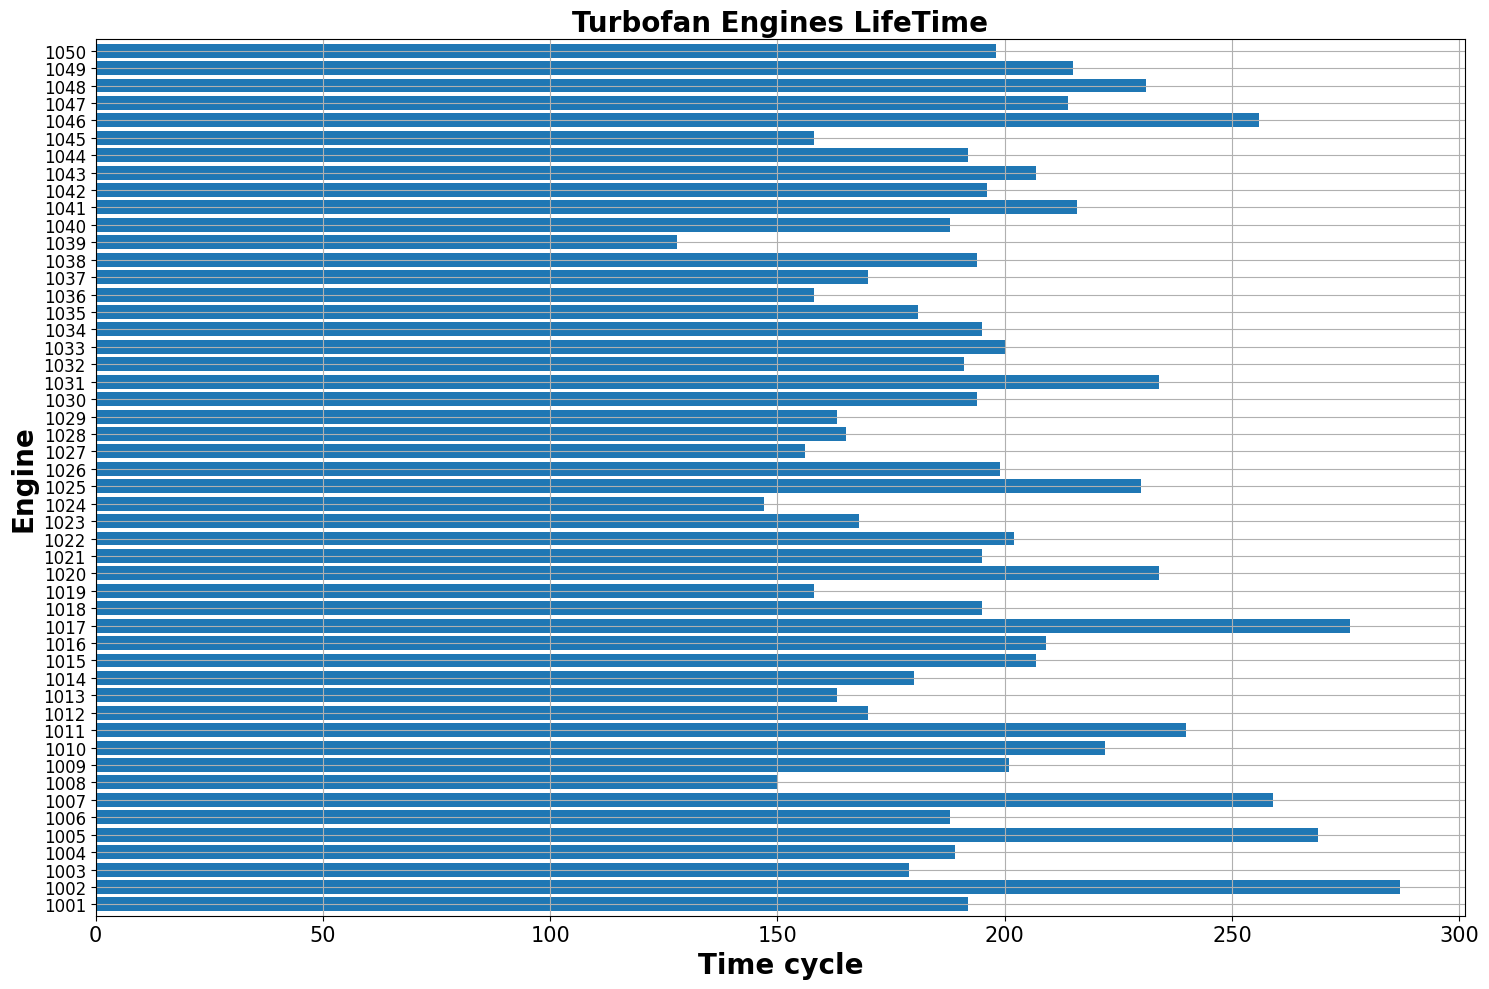

In [84]:
max_time_cycles=x_100[['id','cycle']].groupby('id').max()
plt.figure(figsize=(15,10))
ax=max_time_cycles['cycle'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=20)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('Engine',fontweight='bold',size=20)
plt.yticks(size=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [87]:
max_time_cycles_2=train_df[['id','cycle']].groupby('id').max()

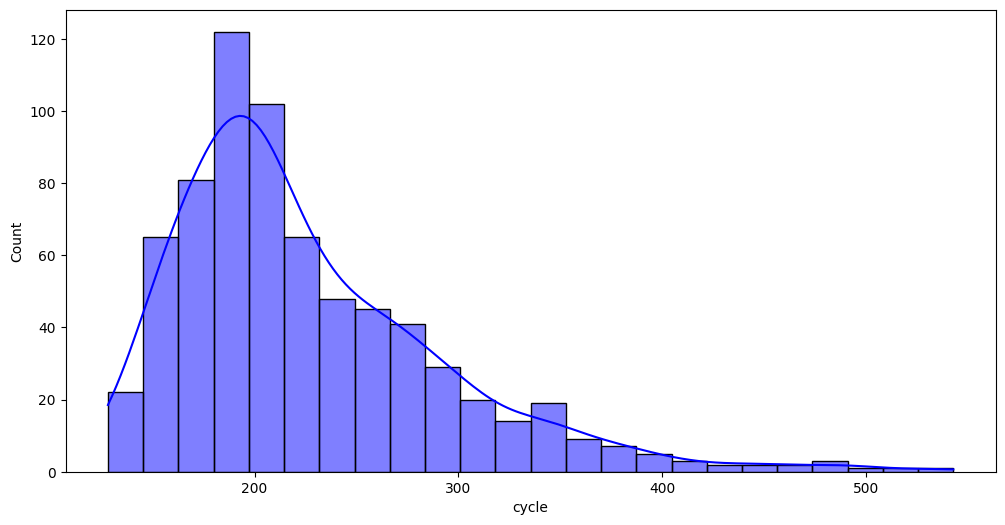

In [88]:

plt.subplots(figsize=(12, 6))
sns.histplot(max_time_cycles_2["cycle"], kde = True, color='blue');


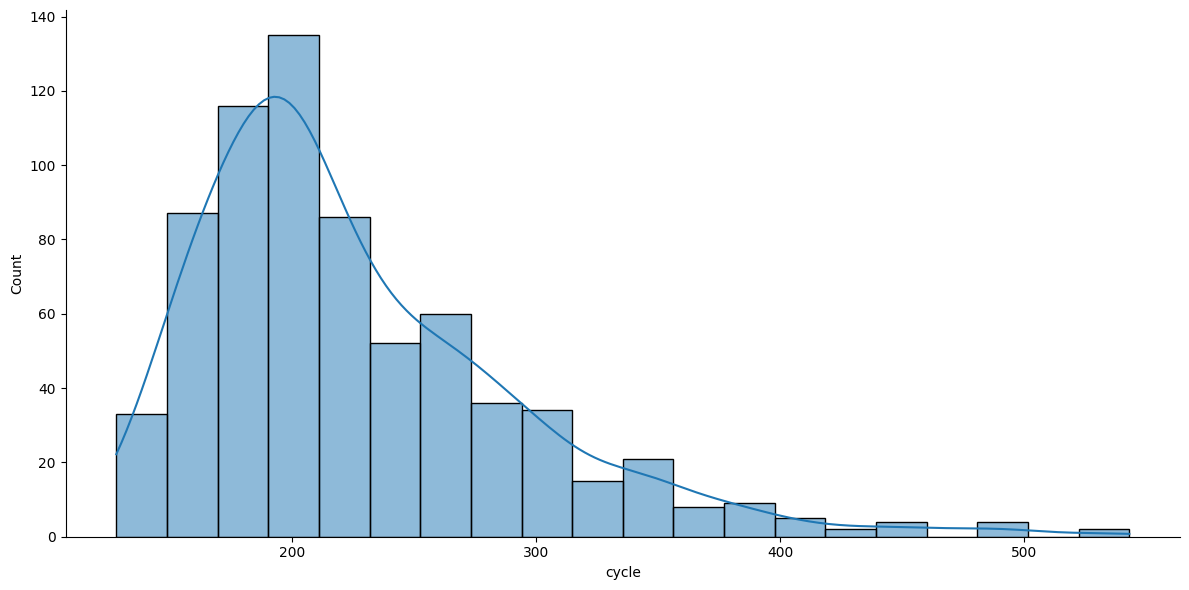

In [89]:
sns.displot(max_time_cycles_2['cycle'],kde=True,bins=20,height=6,aspect=2)

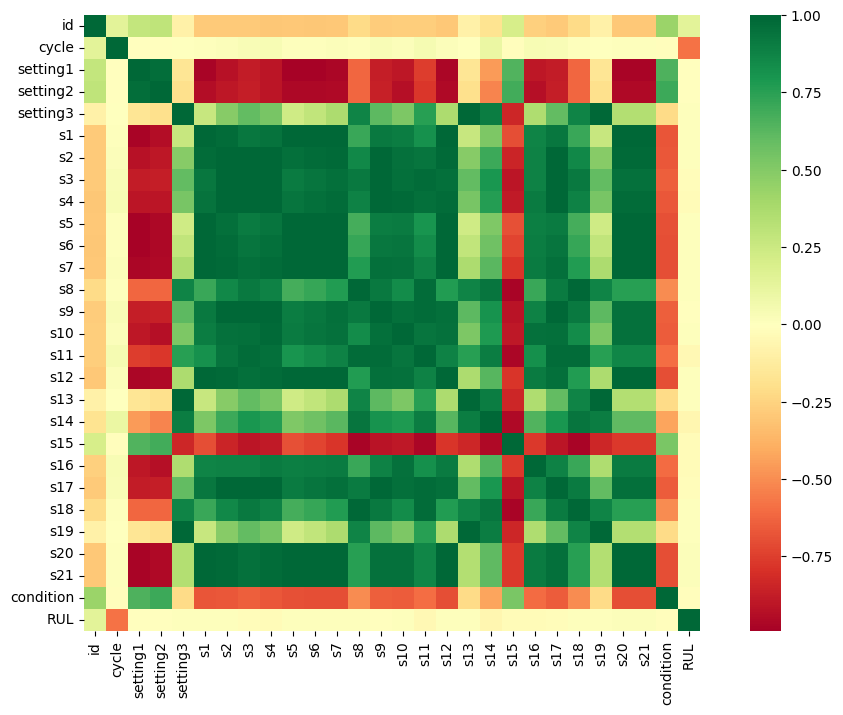

In [101]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(50, 10, as_cmap=True)
sns.heatmap(train_df.corr(), cmap ='RdYlGn', center=0, annot=False, square=True);

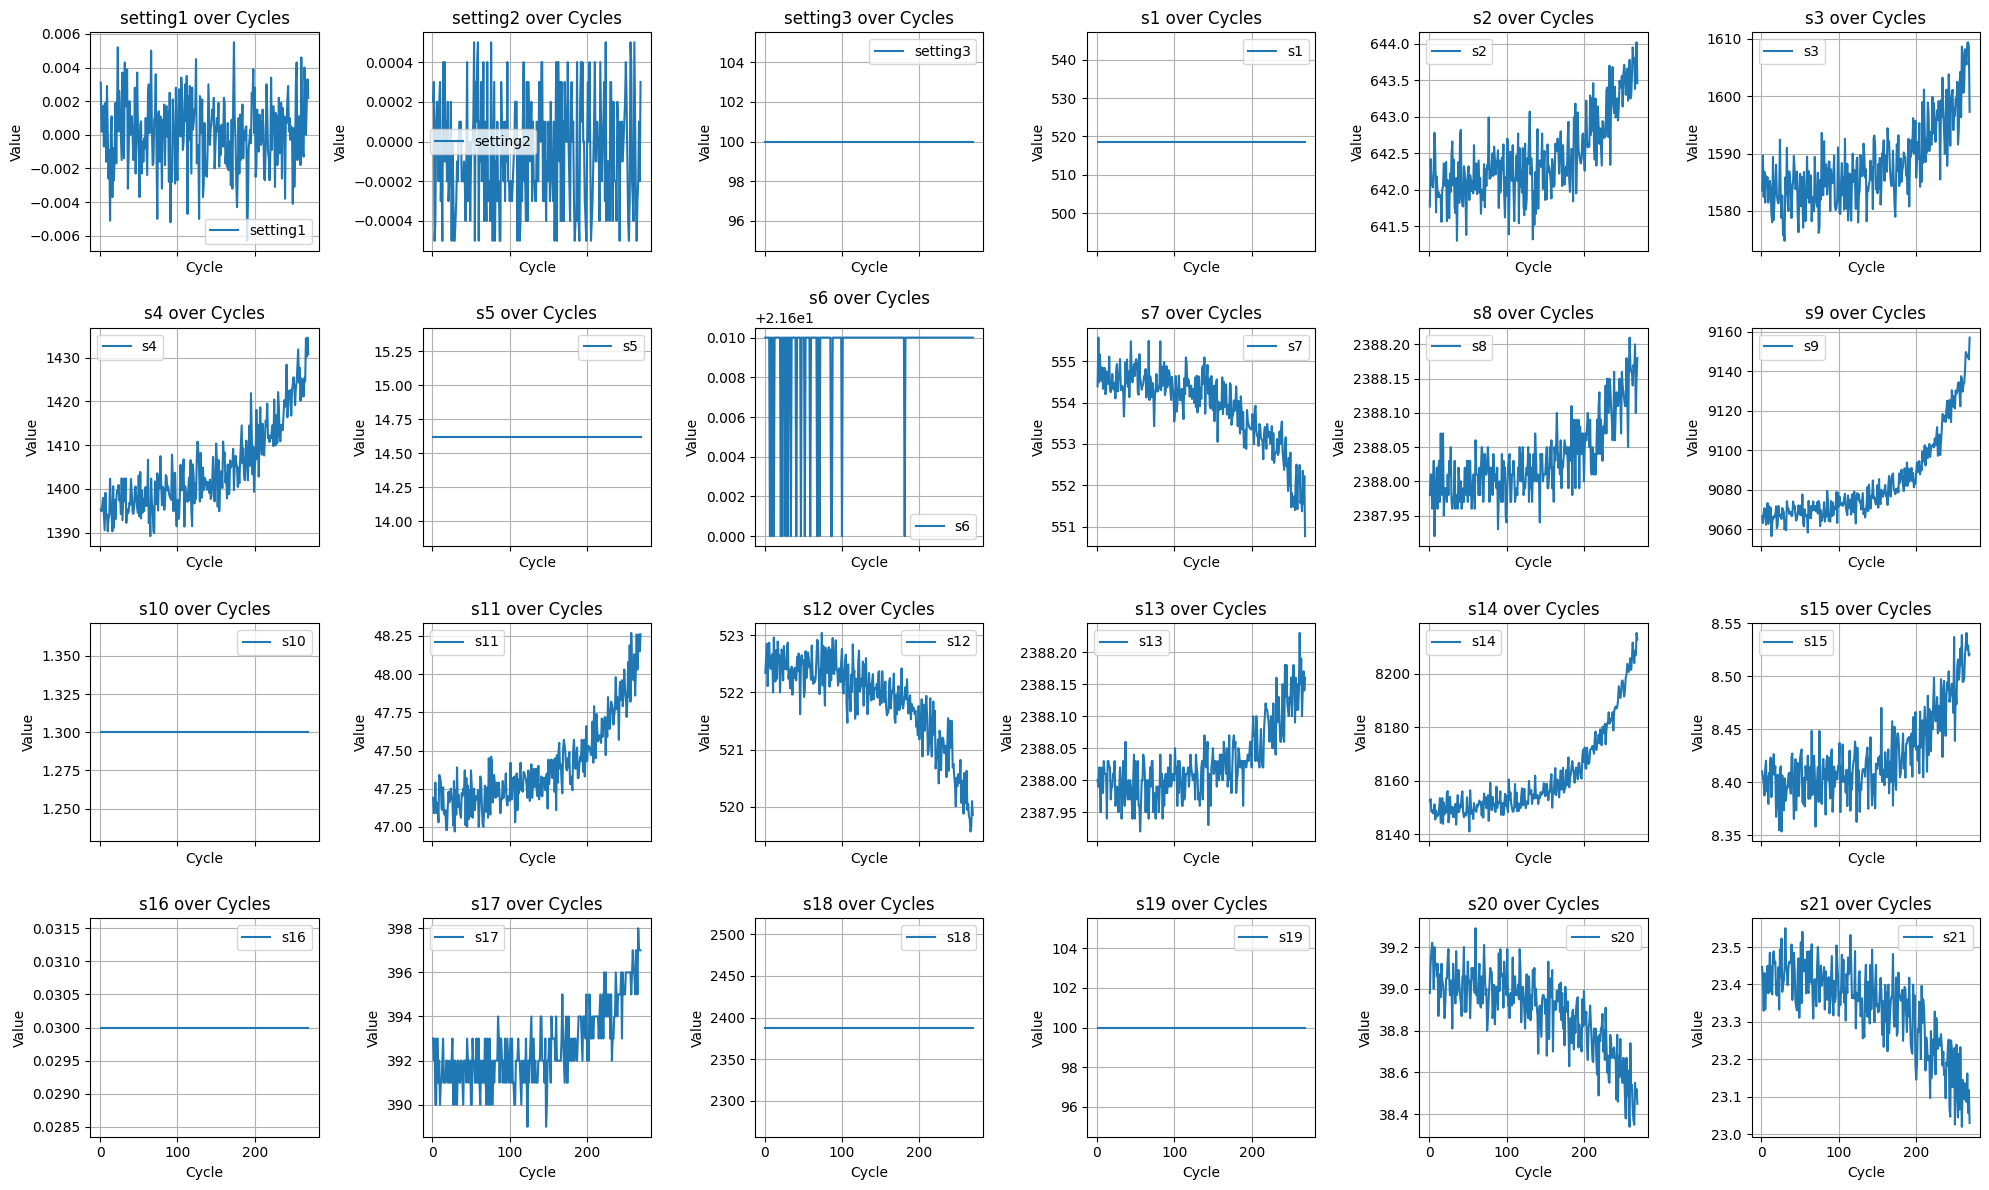

In [106]:
engine_number = 1 # Replace with the engine number you want to analyze
engine_data = train_df[train_df['id'] == 1005]

# The list contains all setting and sensor columns
columns_to_plot = ['setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]

# The list contains all the setting and sensor columns
num_columns = 6
num_rows = (len(columns_to_plot) + num_columns - 1) // num_columns  # 计算行数
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 3), sharex=True)

# Plot individual line plots for each setting and sensor
for ax, column in zip(axes.flatten(), columns_to_plot):
    ax.plot(engine_data['cycle'], engine_data[column], label=column)
    ax.set_title(f'{column} over Cycles')
    ax.set_xlabel('Cycle')
    ax.set_ylabel('Value')
    ax.legend()
    ax.grid(True)

# Adjust the layout so that subgraphs do not overlap
plt.tight_layout()
plt.show()